In [7]:
%matplotlib inline


# Matrix Multiplication
In this tutorial, you will write a 25-lines high-performance FP16 matrix multiplication
kernel that achieves performance on par with cuBLAS.
You will specifically learn about:

- Block-level matrix multiplications
- Multi-dimensional pointer arithmetic
- Program re-ordering for improved L2 cache hit rate
- Automatic performance tuning


## Motivations
Matrix multiplications are a key building block of most modern high-performance computing systems.
They are notoriously hard to optimize, hence their implementation is generally done by
hardware vendors themselves as part of so-called "kernel libraries" (e.g., cuBLAS).
Unfortunately, these libraries are often proprietary and cannot be easily customized
to accomodate the needs of modern deep learning workloads (e.g., fused activation functions).
In this tutorial, you will learn how to implement efficient matrix multiplications by
yourself with Triton, in a way that is easy to customize and extend.

Roughly speaking, the kernel that we will write will implement the following blocked
algorithm to multiply a (M, K) by a (K, N) matrix:

 .. code-block:: python

   # do in parallel
   for m in range(0, M, BLOCK_SIZE_M):
     # do in parallel
     for n in range(0, N, BLOCK_SIZE_N):
       acc = zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=float32)
       for k in range(0, K, BLOCK_SIZE_K):
         a = A[m : m+BLOCK_SIZE_M, k : k+BLOCK_SIZE_K]
         b = B[k : k+BLOCK_SIZE_K, n : n+BLOCK_SIZE_N]
         acc += dot(a, b)
       C[m : m+BLOCK_SIZE_M, n : n+BLOCK_SIZE_N] = acc;

where each iteration of the doubly-nested for-loop is performed by a dedicated Triton program instance.



## Compute Kernel

The above algorithm is, actually, fairly straightforward to implement in Triton.
The main difficulty comes from the computation of the memory locations at which blocks
of :code:`A` and :code:`B` must be read in the inner loop. For that, we need
multi-dimensional pointer arithmetics.

### Pointer Arithmetics

For a row-major 2D tensor :code:`X`, the memory location of :code:`X[i, j]` is given b
y :code:`&X[i, j] = X + i*stride_xi + j*stride_xj`.
Therefore, blocks of pointers for :code:`A[m : m+BLOCK_SIZE_M, k:k+BLOCK_SIZE_K]` and
:code:`B[k : k+BLOCK_SIZE_K, n : n+BLOCK_SIZE_N]` can be defined in pseudo-code as:

 .. code-block:: python

   &A[m : m+BLOCK_SIZE_M, k:k+BLOCK_SIZE_K] =  a_ptr + (m : m+BLOCK_SIZE_M)[:, None]*A.stride(0) + (k : k+BLOCK_SIZE_K)[None, :]*A.stride(1);
   &B[k : k+BLOCK_SIZE_K, n:n+BLOCK_SIZE_N] =  b_ptr + (k : k+BLOCK_SIZE_K)[:, None]*B.stride(0) + (n : n+BLOCK_SIZE_N)[None, :]*B.stride(1);

Which means that pointers for blocks of A and B can be initialized (i.e., :code:`k=0`) in Triton as:

 .. code-block:: python

   offs_am = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
   offs_bn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
   offs_k = tl.arange(0, BLOCK_SIZE_K)
   a_ptrs = a_ptr + (offs_am[:, None]*stride_am + offs_k [None, :]*stride_ak)
   b_ptrs = b_ptr + (offs_k [:, None]*stride_bk + offs_bn[None, :]*stride_bn)

And then updated in the inner loop as follows:

 .. code-block:: python

   pa += BLOCK_SIZE_K * stride_ak;
   pb += BLOCK_SIZE_K * stride_bk;


### L2 Cache Optimizations

As mentioned above, each program instance computes a :code:`[BLOCK_SIZE_M, BLOCK_SIZE_N]`
block of :code:`C`.
It is important to remember that the order in which these blocks are computed does
matter, since it affects the L2 cache hit rate of our program. and unfortunately, a
a simple row-major ordering

 .. code-block:: Python

   pid = triton.program_id(0);
   grid_m = (M + BLOCK_SIZE_M - 1) // BLOCK_SIZE_M;
   grid_n = (N + BLOCK_SIZE_N - 1) // BLOCK_SIZE_N;
   pid_m = pid / grid_n;
   pid_n = pid % grid_n;

is just not going to cut it.

One possible solution is to launch blocks in an order that promotes data reuse.
This can be done by 'super-grouping' blocks in groups of :code:`GROUP_M` rows before
switching to the next column:

 .. code-block:: python

   # program ID
   pid = tl.program_id(axis=0)
   # number of program ids along the M axis
   num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
   # number of programs ids along the N axis
   num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
   # number of programs in group
   num_pid_in_group = GROUP_SIZE_M * num_pid_n
   # id of the group this program is in
   group_id = pid // num_pid_in_group
   # row-id of the first program in the group
   first_pid_m = group_id * GROUP_SIZE_M
   # if `num_pid_m` isn't divisible by `GROUP_SIZE_M`, the last group is smaller
   group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
   # *within groups*, programs are ordered in a column-major order
   # row-id of the program in the *launch grid*
   pid_m = first_pid_m + (pid % group_size_m)
   # col-id of the program in the *launch grid*
   pid_n = (pid % num_pid_in_group) // group_size_m

For example, in the following matmul where each matrix is 9 blocks by 9 blocks,
we can see that if we compute the output in row-major ordering, we need to load 90
blocks into SRAM to compute the first 9 output blocks, but if we do it in grouped
ordering, we only need to load 54 blocks.
  .. image:: grouped_vs_row_major_ordering.png

In practice, this can improve the performance of our matrix multiplication kernel by
more than 10\% on some hardware architecture (e.g., 220 to 245 TFLOPS on A100).




## Final Result




In [8]:
import torch

import triton
import triton.language as tl

# %
# :code:`triton.jit`'ed functions can be auto-tuned by using the `triton.autotune`
# decorator, which consumes:
#   - A list of :code:`triton.Config` objects that define different configurations of
#       meta-parameters (e.g., BLOCK_SIZE_M) and compilation options (e.g., num_warps) to try
#   - An autotuning *key* whose change in values will trigger evaluation of all the
#       provided configs


@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        #triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        #triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        #triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        #triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        #triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        #triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        #triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        #triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        #triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
    # Pointers to matrices
    a_ptr, b_ptr, c_ptr,
    # Matrix dimensions
    M, N, K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. stride_am is how much to increase a_ptr
    # by to get the element one row down (A has M rows)
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr,
    ACTIVATION: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse
    # See above `L2 Cache Optimizations` section for details
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # a_ptrs is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # b_ptrs is a block of [BLOCK_SIZE_K, BLOCK_SIZE_n] pointers
    # see above `Pointer Arithmetics` section for details
    offs_am = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_bn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, K, BLOCK_SIZE_K):
        # Note that for simplicity, we don't apply a mask here.
        # This means that if K is not a multiple of BLOCK_SIZE_K,
        # this will access out-of-bounds memory and produce an
        # error or (worse!) incorrect results.
        a = tl.load(a_ptrs)
        b = tl.load(b_ptrs)
        # We accumulate along the K dimension
        accumulator += tl.dot(a, b)
        # Advance the ptrs to the next K block
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # you can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float32)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


# we can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`
@triton.jit
def leaky_relu(x):
    x = x + 1
    return tl.where(x >= 0, x, 0.01 * x)

We can now create a convenience wrapper function that only takes two input tensors
and (1) checks any shape constraint; (2) allocates the output; (3) launches the above kernel



In [9]:
def matmul(a, b, activation=""):
    # checks constraints
    assert a.shape[1] == b.shape[0], "incompatible dimensions"
    assert a.is_contiguous(), "matrix A must be contiguous"
    assert b.is_contiguous(), "matrix B must be contiguous"
    M, K = a.shape
    K, N = b.shape
    assert (
        K % 32 == 0
    ), "We don't check memory-out-of-bounds with K so K must be divisible by BLOCK_SIZE_K"
    # allocates output
    c = torch.empty((M, N), device=a.device, dtype=a.dtype)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
    )
    matmul_kernel[grid](
        a, b, c,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
        ACTIVATION=activation,
    )
    return c

## Unit Test

We can test our custom matrix multiplication operation against a native torch implementation (i.e., cuBLAS)



In [10]:
DTYPE = torch.float32 # Also need to change accumulator.to(...) in the code above
torch.manual_seed(0)
a = torch.randn((512, 512), device='cuda', dtype=DTYPE)
b = torch.randn((512, 512), device='cuda', dtype=DTYPE)
triton_output = matmul(a, b)
torch_output = torch.matmul(a, b)
print(f"triton_output={triton_output}")
print(f"torch_output={torch_output}")
if triton.testing.allclose(triton_output, torch_output):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

triton_output=tensor([[-10.9304,  -4.7002,  15.6790,  ..., -28.3958,   4.3275, -26.3966],
        [ 26.8020,  10.0415,  -5.4263,  ..., -11.2786,  -8.5218,  30.7146],
        [-13.2566,  15.8273,  18.0785,  ..., -21.7405,  -8.6493,  10.2027],
        ...,
        [ 40.2664,  18.5708, -25.5875,  ...,  -2.7424,  -3.2458,  40.9771],
        [ -6.1185, -16.8163,   4.4921,  ..., -21.0206,  24.6943,  15.0004],
        [-17.0823, -18.9816,  -0.3716,  ...,  21.5282, -30.2172, -13.2078]],
       device='cuda:0')
torch_output=tensor([[-10.9519,  -4.7112,  15.6975,  ..., -28.4001,   4.3313, -26.4215],
        [ 26.8393,  10.0491,  -5.4303,  ..., -11.2956,  -8.5285,  30.7465],
        [-13.2595,  15.8482,  18.0791,  ..., -21.7674,  -8.6399,  10.2044],
        ...,
        [ 40.2870,  18.6080, -25.6115,  ...,  -2.7595,  -3.2450,  41.0050],
        [ -6.1226, -16.8355,   4.4847,  ..., -21.0356,  24.7066,  15.0219],
        [-17.0872, -19.0009,  -0.3832,  ...,  21.5546, -30.2271, -13.2215]],
       de

## Benchmark

### Square Matrix Performance
We can now compare the performance of our kernel against that of cuBLAS. Here we focus on square matrices, but feel free to arrange this script as you wish to benchmark any other matrix shape.



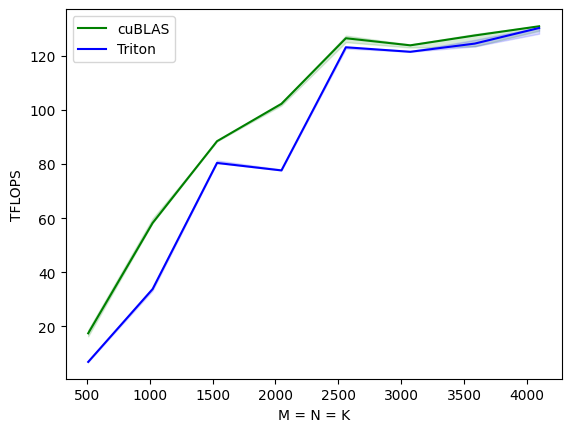

matmul-performance:
        M      cuBLAS      Triton
0   512.0   17.476267    6.898527
1  1024.0   58.254220   33.825033
2  1536.0   88.473602   80.430545
3  2048.0  102.300099   77.672296
4  2560.0  126.517378  123.187975
5  3072.0  123.901763  121.508807
6  3584.0  127.539561  124.536550
7  4096.0  130.944124  130.308468


In [11]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M', 'N', 'K'],  # argument names to use as an x-axis for the plot
        x_vals=[
            512 * i for i in range(1, 9)
        ],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        # possible values for `line_arg``
        line_vals=['cublas', 'triton',],
        # label name for the lines
        line_names=["cuBLAS", "Triton"],
        # line styles
        styles=[('green', '-'),('blue', '-'),],
        ylabel="TFLOPS",  # label name for the y-axis
        plot_name="matmul-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={},
    )
)
def benchmark(M, N, K, provider):
    torch.set_float32_matmul_precision("high")
    a = torch.randn((M, K), device='cuda', dtype=DTYPE)
    b = torch.randn((K, N), device='cuda', dtype=DTYPE)
    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b))
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b))
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)